<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cifar-100-128-fine/resized/15*15/cifar100_fine_15_15_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [4]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/cifar100_128_fine.zip -d cifar100_128_fine

Streaming output truncated to the last 5000 lines.
  inflating: cifar100_128_fine/cifar100_128_fine/test/cloud.8.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/orange.19.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/mountain.21.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/chimpanzee.24.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/computer_keyboard.26.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/rose.29.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/turtle.33.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/beaver.50.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/sweet_pepper.101.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/forest.124.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/snail.151.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/caterpillar.152.jpg  
  inflating: cifar100_128_fine/cifar100_128_fine/test/cup.185.jpg  
  inflating: c

In [15]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42, 42, 57, 48, 86, 7, 15, 28, 39, 52][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 100
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
TRAIN_DIR = "cifar100_128_fine/cifar100_128_fine/train/"
TEST_DIR = "cifar100_128_fine/cifar100_128_fine/test/"
# TEST_DIR = "cifar100_128_fine/cifar100_128_fine/train/"
# TRAIN_DIR = "cifar100_128_fine/cifar100_128_fine/test/"

In [16]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [17]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

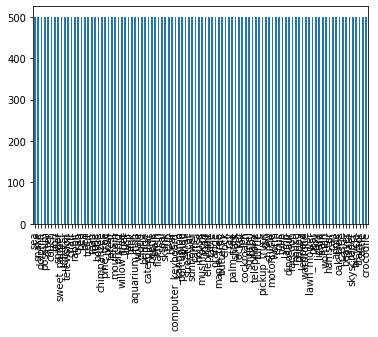

In [18]:
train_df['category'].value_counts().plot.bar()

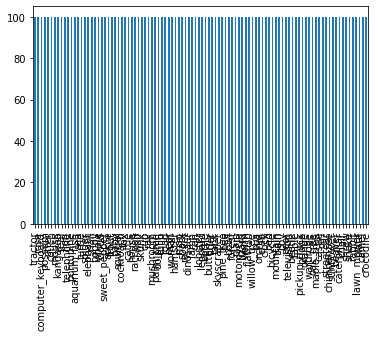

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
train_datagen = ImageDataGenerator(
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 50000 validated image filenames belonging to 100 classes.


In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 100 classes.


In [22]:
print(train_df.shape)
print(validate_df.shape)

(50000, 2)
(10000, 2)


In [23]:
train_generator.image_shape

(128, 128, 3)

In [24]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

100


In [25]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), 
                  padding='same', name="GaborLayer", input_shape=train_generator.image_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.1),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GaborLayer (Conv2D)          (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_12 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_13 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)       

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
1562/1562 [==============================] - 83s 52ms/step - loss: 3.9845 - accuracy: 0.1011 - auc: 0.7641 - val_loss: 3.1555 - val_accuracy: 0.2346 - val_auc: 0.8731
Epoch 2/1000
1562/1562 [==============================] - 81s 52ms/step - loss: 2.7332 - accuracy: 0.3118 - auc: 0.9122 - val_loss: 2.6687 - val_accuracy: 0.3343 - val_auc: 0.9071
Epoch 3/1000
1562/1562 [==============================] - 81s 52ms/step - loss: 2.1545 - accuracy: 0.4331 - auc: 0.9456 - val_loss: 2.4470 - val_accuracy: 0.3814 - val_auc: 0.9168
Epoch 4/1000
1562/1562 [==============================] - 81s 52ms/step - loss: 1.8350 - accuracy: 0.5000 - auc: 0.9605 - val_loss: 1.9070 - val_accuracy: 0.4875 - val_auc: 0.9525
Epoch 5/1000
1562/1562 [==============================] - 81s 52ms/step - loss: 1.5858 - accuracy: 0.5588 - auc: 0.9695 - val_loss: 2.2772 - val_accuracy: 0.4279 - val_auc: 0.9244
Epoch 6/1000
1562/1562 [==============================] - 81s 52ms/step - loss: 1.3543 - accuracy: 0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
312/312 [==============================] - 57s 166ms/step - loss: 4.5369 - accuracy: 0.0324 - auc: 0.6455 - val_loss: 5.1287 - val_accuracy: 0.0531 - val_auc: 0.6710
Epoch 2/1000
312/312 [==============================] - 50s 161ms/step - loss: 3.8352 - accuracy: 0.1162 - auc: 0.8035 - val_loss: 5.7407 - val_accuracy: 0.0761 - val_auc: 0.6485
Epoch 3/1000
312/312 [==============================] - 50s 161ms/step - loss: 3.3564 - accuracy: 0.1931 - auc: 0.8635 - val_loss: 6.5729 - val_accuracy: 0.0660 - val_auc: 0.6249
Epoch 4/1000
312/312 [==============================] - 50s 160ms/step - loss: 2.9144 - accuracy: 0.2709 - auc: 0.9053 - val_loss: 4.3447 - val_accuracy: 0.1520 - val_auc: 0.7564
Epoch 5/1000
312/312 [==============================] - 50s 161ms/step - loss: 2.4667 - accuracy: 0.3673 - auc: 0.9357 - val_loss: 3.9080 - val_accuracy: 0.1878 - val_auc: 0.7990
Epoch 6/1000
312/312 [==============================] - 50s 161ms/step - loss: 1.9675 - accuracy: 0.4828 

KeyboardInterrupt: ignored